In [286]:
import pandas as pd
import numpy as np
import os
import datetime
import sys
import bisect

sys.path.insert(0, '..')

import keras.layers
from keras.layers import Input, Dense, LocallyConnected1D, Reshape
from keras.models import Model
from keras import regularizers
from sklearn import preprocessing

from IPython.display import SVG
from keras.utils import model_to_dot


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [287]:
import umap
import umap.plot

In [288]:
raw_df = pd.read_hdf("../data/processed/summaries_protoss.hdf", "summaries")
raw_df = raw_df[raw_df.game_duration > 280]
raw_df.head()

,game_start,game_duration,self_won,self_name,self_race_is_protoss,self_race_is_zerg,self_race_is_terran,opponent_name,opponent_race_is_protoss,opponent_race_is_zerg,...,TwilightCouncil_start,TwilightCouncil_weight,VoidRay_start,VoidRay_weight,WarpGate_start,WarpGate_weight,WarpPrism_start,WarpPrism_weight,Zealot_start,Zealot_weight
20d6247127ed58eeca069051672d3e8c3598e132d2fc6c445040701499b72acf_0,2020-02-01 15:07:59,675,1.0,ShoWTimE,1.0,0.0,0.0,Trap,1.0,0.0,...,1000.000000,0.000000,1000.0,0.0,13.038405,1.0,1000.0,0.0,1000.000000,0.0
20d6247127ed58eeca069051672d3e8c3598e132d2fc6c445040701499b72acf_1,2020-02-01 15:07:59,675,0.0,Trap,1.0,0.0,0.0,ShoWTimE,1.0,0.0,...,1000.000000,0.000000,1000.0,0.0,13.000000,1.0,1000.0,0.0,1000.000000,0.0
50cb3b2f33692227e2e50e0e4fab529a44c4bfe9bfd9e8137c08a81e94f08370_1,2020-02-02 12:13:08,886,0.0,ShoWTimE,1.0,0.0,0.0,cure,0.0,0.0,...,13.856406,1.000000,1000.0,0.0,13.114877,1.0,1000.0,0.0,13.266499,1.0
038ca41ecf0198facf7425bfd5cfa9237f144e4e41d9c556b204612d55088de1_1,2020-02-02 13:34:45,825,0.0,ShoWTimE,1.0,0.0,0.0,cure,0.0,0.0,...,14.764823,1.927659,1000.0,0.0,13.416408,1.0,1000.0,0.0,1000.000000,0.0
eaa36f7eff9c1682c86aace4ff319bce335f3d61c6e362432c504618e3a95055_0,2020-02-01 14:58:20,531,0.0,ShoWTimE,1.0,0.0,0.0,Trap,1.0,0.0,...,1000.000000,0.000000,1000.0,0.0,13.000000,1.0,1000.0,0.0,1000.000000,0.0


In [289]:
metadata_columns = """
self_won
game_start
game_duration
self_name self_race_is_protoss self_race_is_zerg self_race_is_terran
opponent_name
""".split()
weight_columns = [col for col in raw_df.columns if col.endswith("_weight")]

data_columns = [col for col in raw_df.columns if col not in metadata_columns and col not in weight_columns]

df = raw_df[data_columns]
min_max_scaler = preprocessing.MinMaxScaler()
df = pd.DataFrame(min_max_scaler.fit_transform(df), columns=df.columns, index=df.index)

encoding_dim = 10

In [290]:
len(data_columns)


48

In [291]:
input_data = Input(shape=(len(df.columns),))

#encoded = Dense(20, activation='relu')(input_data)

encoded = Dense(encoding_dim, activation='relu')(input_data)

#decoded = Dense(20, activation='relu')(encoded)

decoded = Dense(len(df.columns), activation='sigmoid')(encoded)

autoencoder = Model(input_data, decoded)


In [292]:
encoder = Model(input_data, encoded)


1018


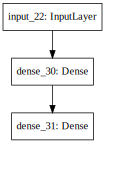

In [293]:
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
print(autoencoder.count_params())
SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))


In [294]:
x_all = df.sample(frac=1.0).values
num_samples = int(0.95 * x_all.shape[0])
x_train, x_test = x_all[:num_samples, :], x_all[num_samples:, :]
print("Training on {} samples. Testing on {}.".format(
    num_samples, x_all.shape[0] - num_samples))


Training on 2855 samples. Testing on 151.


In [295]:
history = autoencoder.fit(x_train, x_train,
                epochs=2000,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))


Train on 2855 samples, validate on 151 samples
Epoch 1/2000
2855/2855 [==============================] - 0s 28us/step - loss: 0.2605 - val_loss: 0.2541
Epoch 2/2000
2855/2855 [==============================] - 0s 5us/step - loss: 0.2516 - val_loss: 0.2459
Epoch 3/2000
2855/2855 [==============================] - 0s 5us/step - loss: 0.2436 - val_loss: 0.2385
Epoch 4/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.2363 - val_loss: 0.2316
Epoch 5/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.2294 - val_loss: 0.2251
Epoch 6/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.2229 - val_loss: 0.2187
Epoch 7/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.2164 - val_loss: 0.2123
Epoch 8/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.2100 - val_loss: 0.2059
Epoch 9/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.2034 - val_loss: 0.1993
Epoch 10/2000
28

2855/2855 [==============================] - 0s 3us/step - loss: 0.0588 - val_loss: 0.0601
Epoch 79/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0588 - val_loss: 0.0601
Epoch 80/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0587 - val_loss: 0.0600
Epoch 81/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0586 - val_loss: 0.0599
Epoch 82/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0585 - val_loss: 0.0598
Epoch 83/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0585 - val_loss: 0.0597
Epoch 84/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0584 - val_loss: 0.0597
Epoch 85/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0583 - val_loss: 0.0596
Epoch 86/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0583 - val_loss: 0.0595
Epoch 87/2000
2855/2855 [==============================] - 0s 4us/ste

2855/2855 [==============================] - 0s 3us/step - loss: 0.0503 - val_loss: 0.0507
Epoch 156/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0501 - val_loss: 0.0505
Epoch 157/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0500 - val_loss: 0.0503
Epoch 158/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0498 - val_loss: 0.0501
Epoch 159/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0496 - val_loss: 0.0499
Epoch 160/2000
2855/2855 [==============================] - 0s 2us/step - loss: 0.0495 - val_loss: 0.0498
Epoch 161/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0493 - val_loss: 0.0496
Epoch 162/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0491 - val_loss: 0.0494
Epoch 163/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0490 - val_loss: 0.0492
Epoch 164/2000
2855/2855 [==============================] - 0

2855/2855 [==============================] - 0s 3us/step - loss: 0.0390 - val_loss: 0.0387
Epoch 233/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0389 - val_loss: 0.0386
Epoch 234/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0388 - val_loss: 0.0385
Epoch 235/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0387 - val_loss: 0.0384
Epoch 236/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0386 - val_loss: 0.0383
Epoch 237/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0385 - val_loss: 0.0382
Epoch 238/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0384 - val_loss: 0.0381
Epoch 239/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0383 - val_loss: 0.0380
Epoch 240/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0382 - val_loss: 0.0379
Epoch 241/2000
2855/2855 [==============================] - 0

2855/2855 [==============================] - 0s 5us/step - loss: 0.0318 - val_loss: 0.0315
Epoch 310/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0318 - val_loss: 0.0314
Epoch 311/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0317 - val_loss: 0.0314
Epoch 312/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0316 - val_loss: 0.0313
Epoch 313/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0315 - val_loss: 0.0312
Epoch 314/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0314 - val_loss: 0.0311
Epoch 315/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0314 - val_loss: 0.0310
Epoch 316/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0313 - val_loss: 0.0310
Epoch 317/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0312 - val_loss: 0.0309
Epoch 318/2000
2855/2855 [==============================] - 0

2855/2855 [==============================] - 0s 4us/step - loss: 0.0267 - val_loss: 0.0263
Epoch 387/2000
2855/2855 [==============================] - 0s 5us/step - loss: 0.0266 - val_loss: 0.0262
Epoch 388/2000
2855/2855 [==============================] - 0s 5us/step - loss: 0.0266 - val_loss: 0.0262
Epoch 389/2000
2855/2855 [==============================] - 0s 5us/step - loss: 0.0265 - val_loss: 0.0261
Epoch 390/2000
2855/2855 [==============================] - 0s 5us/step - loss: 0.0265 - val_loss: 0.0261
Epoch 391/2000
2855/2855 [==============================] - 0s 5us/step - loss: 0.0264 - val_loss: 0.0260
Epoch 392/2000
2855/2855 [==============================] - 0s 5us/step - loss: 0.0263 - val_loss: 0.0260
Epoch 393/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0263 - val_loss: 0.0259
Epoch 394/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0262 - val_loss: 0.0259
Epoch 395/2000
2855/2855 [==============================] - 0

2855/2855 [==============================] - 0s 4us/step - loss: 0.0232 - val_loss: 0.0228
Epoch 464/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0232 - val_loss: 0.0227
Epoch 465/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0231 - val_loss: 0.0227
Epoch 466/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0231 - val_loss: 0.0227
Epoch 467/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0231 - val_loss: 0.0226
Epoch 468/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0230 - val_loss: 0.0226
Epoch 469/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0230 - val_loss: 0.0226
Epoch 470/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0229 - val_loss: 0.0225
Epoch 471/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0229 - val_loss: 0.0225
Epoch 472/2000
2855/2855 [==============================] - 0

2855/2855 [==============================] - 0s 4us/step - loss: 0.0207 - val_loss: 0.0203
Epoch 541/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0207 - val_loss: 0.0203
Epoch 542/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0206 - val_loss: 0.0202
Epoch 543/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0206 - val_loss: 0.0202
Epoch 544/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0206 - val_loss: 0.0202
Epoch 545/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0206 - val_loss: 0.0202
Epoch 546/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0205 - val_loss: 0.0201
Epoch 547/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0205 - val_loss: 0.0201
Epoch 548/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0205 - val_loss: 0.0201
Epoch 549/2000
2855/2855 [==============================] - 0

2855/2855 [==============================] - 0s 4us/step - loss: 0.0187 - val_loss: 0.0184
Epoch 618/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0187 - val_loss: 0.0184
Epoch 619/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0187 - val_loss: 0.0184
Epoch 620/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0187 - val_loss: 0.0183
Epoch 621/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0187 - val_loss: 0.0183
Epoch 622/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0186 - val_loss: 0.0183
Epoch 623/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0186 - val_loss: 0.0183
Epoch 624/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0186 - val_loss: 0.0183
Epoch 625/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0186 - val_loss: 0.0182
Epoch 626/2000
2855/2855 [==============================] - 0

2855/2855 [==============================] - 0s 3us/step - loss: 0.0172 - val_loss: 0.0169
Epoch 695/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0171 - val_loss: 0.0169
Epoch 696/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0171 - val_loss: 0.0169
Epoch 697/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0171 - val_loss: 0.0168
Epoch 698/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0171 - val_loss: 0.0168
Epoch 699/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0171 - val_loss: 0.0168
Epoch 700/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0170 - val_loss: 0.0168
Epoch 701/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0170 - val_loss: 0.0168
Epoch 702/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0170 - val_loss: 0.0168
Epoch 703/2000
2855/2855 [==============================] - 0

2855/2855 [==============================] - 0s 3us/step - loss: 0.0158 - val_loss: 0.0156
Epoch 772/2000
2855/2855 [==============================] - 0s 5us/step - loss: 0.0158 - val_loss: 0.0156
Epoch 773/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0158 - val_loss: 0.0156
Epoch 774/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0157 - val_loss: 0.0156
Epoch 775/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0157 - val_loss: 0.0156
Epoch 776/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0157 - val_loss: 0.0155
Epoch 777/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0157 - val_loss: 0.0155
Epoch 778/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0157 - val_loss: 0.0155
Epoch 779/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0157 - val_loss: 0.0155
Epoch 780/2000
2855/2855 [==============================] - 0

2855/2855 [==============================] - 0s 3us/step - loss: 0.0146 - val_loss: 0.0145
Epoch 849/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0146 - val_loss: 0.0145
Epoch 850/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0146 - val_loss: 0.0145
Epoch 851/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0146 - val_loss: 0.0144
Epoch 852/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0146 - val_loss: 0.0144
Epoch 853/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0145 - val_loss: 0.0144
Epoch 854/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0145 - val_loss: 0.0144
Epoch 855/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0145 - val_loss: 0.0144
Epoch 856/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0145 - val_loss: 0.0144
Epoch 857/2000
2855/2855 [==============================] - 0

2855/2855 [==============================] - 0s 3us/step - loss: 0.0136 - val_loss: 0.0134
Epoch 926/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0136 - val_loss: 0.0134
Epoch 927/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0135 - val_loss: 0.0134
Epoch 928/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0135 - val_loss: 0.0133
Epoch 929/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0135 - val_loss: 0.0133
Epoch 930/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0135 - val_loss: 0.0133
Epoch 931/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0135 - val_loss: 0.0133
Epoch 932/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0135 - val_loss: 0.0133
Epoch 933/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0135 - val_loss: 0.0133
Epoch 934/2000
2855/2855 [==============================] - 0

2855/2855 [==============================] - 0s 3us/step - loss: 0.0127 - val_loss: 0.0124
Epoch 1003/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0127 - val_loss: 0.0124
Epoch 1004/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0127 - val_loss: 0.0124
Epoch 1005/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0127 - val_loss: 0.0124
Epoch 1006/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0127 - val_loss: 0.0124
Epoch 1007/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0126 - val_loss: 0.0124
Epoch 1008/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0126 - val_loss: 0.0124
Epoch 1009/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0126 - val_loss: 0.0123
Epoch 1010/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0126 - val_loss: 0.0123
Epoch 1011/2000
2855/2855 [==========================

2855/2855 [==============================] - 0s 5us/step - loss: 0.0120 - val_loss: 0.0117
Epoch 1079/2000
2855/2855 [==============================] - 0s 5us/step - loss: 0.0120 - val_loss: 0.0116
Epoch 1080/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0120 - val_loss: 0.0116
Epoch 1081/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0120 - val_loss: 0.0116
Epoch 1082/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0119 - val_loss: 0.0116
Epoch 1083/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0119 - val_loss: 0.0116
Epoch 1084/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0119 - val_loss: 0.0116
Epoch 1085/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0119 - val_loss: 0.0116
Epoch 1086/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0119 - val_loss: 0.0116
Epoch 1087/2000
2855/2855 [==========================

2855/2855 [==============================] - 0s 3us/step - loss: 0.0114 - val_loss: 0.0110
Epoch 1155/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0114 - val_loss: 0.0110
Epoch 1156/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0114 - val_loss: 0.0110
Epoch 1157/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0114 - val_loss: 0.0110
Epoch 1158/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0114 - val_loss: 0.0110
Epoch 1159/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0113 - val_loss: 0.0110
Epoch 1160/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0113 - val_loss: 0.0110
Epoch 1161/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0113 - val_loss: 0.0110
Epoch 1162/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0113 - val_loss: 0.0110
Epoch 1163/2000
2855/2855 [==========================

2855/2855 [==============================] - 0s 3us/step - loss: 0.0109 - val_loss: 0.0105
Epoch 1231/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0109 - val_loss: 0.0105
Epoch 1232/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0108 - val_loss: 0.0105
Epoch 1233/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0108 - val_loss: 0.0105
Epoch 1234/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0108 - val_loss: 0.0105
Epoch 1235/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0108 - val_loss: 0.0104
Epoch 1236/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0108 - val_loss: 0.0104
Epoch 1237/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0108 - val_loss: 0.0104
Epoch 1238/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0108 - val_loss: 0.0104
Epoch 1239/2000
2855/2855 [==========================

2855/2855 [==============================] - 0s 3us/step - loss: 0.0104 - val_loss: 0.0100
Epoch 1307/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0104 - val_loss: 0.0100
Epoch 1308/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0104 - val_loss: 0.0100
Epoch 1309/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0104 - val_loss: 0.0100
Epoch 1310/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0104 - val_loss: 0.0100
Epoch 1311/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0104 - val_loss: 0.0100
Epoch 1312/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0104 - val_loss: 0.0100
Epoch 1313/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0104 - val_loss: 0.0100
Epoch 1314/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0103 - val_loss: 0.0100
Epoch 1315/2000
2855/2855 [==========================

2855/2855 [==============================] - 0s 3us/step - loss: 0.0100 - val_loss: 0.0096
Epoch 1383/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0100 - val_loss: 0.0096
Epoch 1384/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0100 - val_loss: 0.0096
Epoch 1385/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0100 - val_loss: 0.0096
Epoch 1386/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0099 - val_loss: 0.0096
Epoch 1387/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0099 - val_loss: 0.0095
Epoch 1388/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0099 - val_loss: 0.0095
Epoch 1389/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0099 - val_loss: 0.0095
Epoch 1390/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0099 - val_loss: 0.0095
Epoch 1391/2000
2855/2855 [==========================

2855/2855 [==============================] - 0s 4us/step - loss: 0.0096 - val_loss: 0.0092
Epoch 1459/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0096 - val_loss: 0.0092
Epoch 1460/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0096 - val_loss: 0.0092
Epoch 1461/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0095 - val_loss: 0.0092
Epoch 1462/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0095 - val_loss: 0.0092
Epoch 1463/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0095 - val_loss: 0.0091
Epoch 1464/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0095 - val_loss: 0.0091
Epoch 1465/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0095 - val_loss: 0.0091
Epoch 1466/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0095 - val_loss: 0.0091
Epoch 1467/2000
2855/2855 [==========================

2855/2855 [==============================] - 0s 3us/step - loss: 0.0092 - val_loss: 0.0088
Epoch 1535/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0092 - val_loss: 0.0088
Epoch 1536/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0092 - val_loss: 0.0088
Epoch 1537/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0092 - val_loss: 0.0088
Epoch 1538/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0092 - val_loss: 0.0088
Epoch 1539/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0091 - val_loss: 0.0088
Epoch 1540/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0091 - val_loss: 0.0088
Epoch 1541/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0091 - val_loss: 0.0087
Epoch 1542/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0091 - val_loss: 0.0087
Epoch 1543/2000
2855/2855 [==========================

2855/2855 [==============================] - 0s 4us/step - loss: 0.0088 - val_loss: 0.0084
Epoch 1611/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0088 - val_loss: 0.0084
Epoch 1612/2000
2855/2855 [==============================] - 0s 5us/step - loss: 0.0088 - val_loss: 0.0084
Epoch 1613/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0088 - val_loss: 0.0084
Epoch 1614/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0088 - val_loss: 0.0084
Epoch 1615/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0088 - val_loss: 0.0084
Epoch 1616/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0088 - val_loss: 0.0084
Epoch 1617/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0088 - val_loss: 0.0084
Epoch 1618/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0087 - val_loss: 0.0084
Epoch 1619/2000
2855/2855 [==========================

2855/2855 [==============================] - 0s 3us/step - loss: 0.0084 - val_loss: 0.0080
Epoch 1687/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0084 - val_loss: 0.0080
Epoch 1688/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0084 - val_loss: 0.0080
Epoch 1689/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0084 - val_loss: 0.0080
Epoch 1690/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0084 - val_loss: 0.0080
Epoch 1691/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0084 - val_loss: 0.0080
Epoch 1692/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0084 - val_loss: 0.0080
Epoch 1693/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0084 - val_loss: 0.0080
Epoch 1694/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0084 - val_loss: 0.0080
Epoch 1695/2000
2855/2855 [==========================

2855/2855 [==============================] - 0s 5us/step - loss: 0.0080 - val_loss: 0.0076
Epoch 1763/2000
2855/2855 [==============================] - 0s 5us/step - loss: 0.0080 - val_loss: 0.0076
Epoch 1764/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0080 - val_loss: 0.0076
Epoch 1765/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0080 - val_loss: 0.0076
Epoch 1766/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0080 - val_loss: 0.0076
Epoch 1767/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0080 - val_loss: 0.0076
Epoch 1768/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0080 - val_loss: 0.0076
Epoch 1769/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0080 - val_loss: 0.0076
Epoch 1770/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0080 - val_loss: 0.0076
Epoch 1771/2000
2855/2855 [==========================

2855/2855 [==============================] - 0s 4us/step - loss: 0.0077 - val_loss: 0.0072
Epoch 1839/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0077 - val_loss: 0.0072
Epoch 1840/2000
2855/2855 [==============================] - 0s 5us/step - loss: 0.0077 - val_loss: 0.0072
Epoch 1841/2000
2855/2855 [==============================] - 0s 5us/step - loss: 0.0076 - val_loss: 0.0072
Epoch 1842/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0076 - val_loss: 0.0072
Epoch 1843/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0076 - val_loss: 0.0072
Epoch 1844/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0076 - val_loss: 0.0072
Epoch 1845/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0076 - val_loss: 0.0072
Epoch 1846/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0076 - val_loss: 0.0072
Epoch 1847/2000
2855/2855 [==========================

2855/2855 [==============================] - 0s 3us/step - loss: 0.0073 - val_loss: 0.0069
Epoch 1915/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0073 - val_loss: 0.0069
Epoch 1916/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0073 - val_loss: 0.0069
Epoch 1917/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0073 - val_loss: 0.0069
Epoch 1918/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0073 - val_loss: 0.0069
Epoch 1919/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0073 - val_loss: 0.0069
Epoch 1920/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0073 - val_loss: 0.0069
Epoch 1921/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0073 - val_loss: 0.0069
Epoch 1922/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0073 - val_loss: 0.0068
Epoch 1923/2000
2855/2855 [==========================

2855/2855 [==============================] - 0s 3us/step - loss: 0.0070 - val_loss: 0.0065
Epoch 1991/2000
2855/2855 [==============================] - 0s 5us/step - loss: 0.0070 - val_loss: 0.0065
Epoch 1992/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0070 - val_loss: 0.0065
Epoch 1993/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0070 - val_loss: 0.0065
Epoch 1994/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0070 - val_loss: 0.0065
Epoch 1995/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0070 - val_loss: 0.0065
Epoch 1996/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0070 - val_loss: 0.0065
Epoch 1997/2000
2855/2855 [==============================] - 0s 4us/step - loss: 0.0070 - val_loss: 0.0065
Epoch 1998/2000
2855/2855 [==============================] - 0s 3us/step - loss: 0.0070 - val_loss: 0.0065
Epoch 1999/2000
2855/2855 [==========================

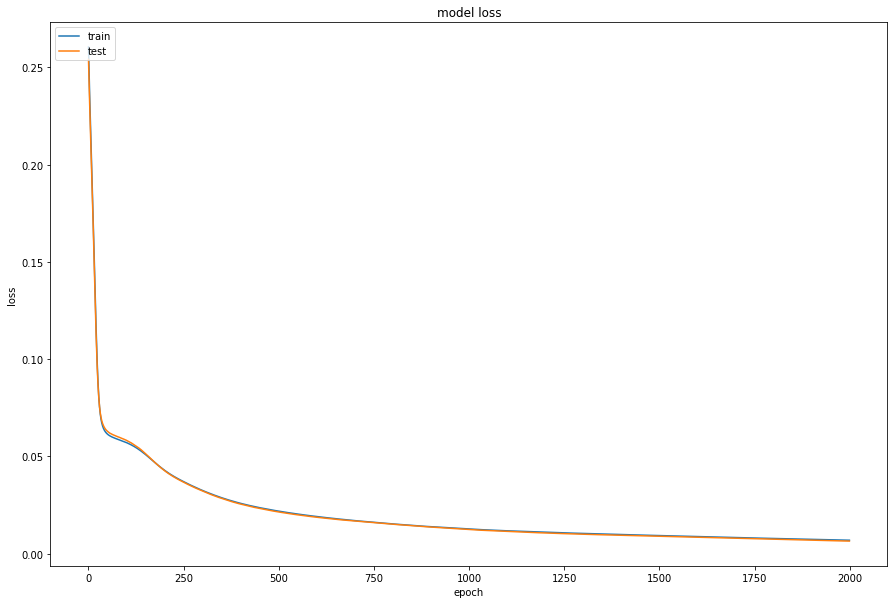

In [296]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [297]:
cluster_games_df = raw_df[raw_df.game_start > datetime.datetime(2020, 1, 1)]
original_space = min_max_scaler.transform(cluster_games_df[data_columns].values)
encoded_space =autoencoder.predict(original_space)

In [298]:
encoded_space[0]

array([9.49581325e-01, 1.85441785e-02, 2.90240627e-02, 9.22327340e-01,
       9.68012750e-01, 9.99926567e-01, 1.06359599e-03, 9.98119295e-01,
       8.20903457e-04, 9.98590410e-01, 2.42731054e-04, 2.82155792e-03,
       9.95830834e-01, 8.90271622e-04, 3.22939642e-03, 2.45071761e-03,
       1.17956672e-03, 9.99956369e-01, 9.95533705e-01, 1.03165895e-01,
       2.85768212e-04, 3.99687007e-04, 9.98010337e-01, 5.27117308e-03,
       9.10915911e-01, 3.10844829e-04, 2.84073018e-02, 9.91918266e-01,
       9.99759614e-01, 1.52029353e-03, 9.99889970e-01, 9.98967052e-01,
       5.45601882e-02, 3.85790784e-03, 4.80446190e-01, 9.99827743e-01,
       3.87209617e-02, 8.97291582e-03, 8.99293125e-01, 4.96843131e-06,
       9.96883571e-01, 2.42754206e-04, 6.14899816e-03, 9.82078850e-01,
       9.98056412e-01, 3.38124647e-03, 8.78402650e-01, 9.62577760e-01],
      dtype=float32)

In [299]:
original_space[0]

array([1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 3.21960918e-03, 1.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 6.27809621e-04,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 1.00000000e+00, 9.46047043e-02,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 6.68062498e-03, 1.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.66553965e-01, 1.00000000e+00,
       2.58908561e-03, 1.17761492e-04, 1.00000000e+00, 1.96849265e-04,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 4.34361690e-04, 1.00000000e+00, 1.00000000e+00])

In [300]:
diffs = encoded_space - original_space
cluster_games_df['creativity'] = np.einsum("ij,ij->i", diffs, diffs)

<ipython-input-300-e9fec5a3d2b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_games_df['creativity'] = np.einsum("ij,ij->i", diffs, diffs)


In [301]:
creative_games_df= cluster_games_df.sort_values('creativity')
creative_games_won = creative_games_df[creative_games_df['self_won'] > 0]
creative_games_won.tail(20)

,game_start,game_duration,self_won,self_name,self_race_is_protoss,self_race_is_zerg,self_race_is_terran,opponent_name,opponent_race_is_protoss,opponent_race_is_zerg,...,TwilightCouncil_weight,VoidRay_start,VoidRay_weight,WarpGate_start,WarpGate_weight,WarpPrism_start,WarpPrism_weight,Zealot_start,Zealot_weight,creativity
8e29ee27b4698c960c692ef3e4d5cbf84af057db2dcaf8bff582ad791c9b0c53_1,2020-01-10 12:19:35,594,1.0,<сSсǃ>SKillous,1.0,0.0,0.0,<KOVA>Mixu,0.0,1.0,...,0.0,1000.000000,0.000000,16.062378,1.000000,1000.000000,0.000000,1000.000000,0.000000,1.269231
b7d1978255012945c602bc1eade31cb8336e06e4e9b73b062f5a7ddececabb82_1,2020-01-05 18:32:15,518,1.0,<Mkers>MaxPax,1.0,0.0,0.0,<SТАR>BratOK,0.0,0.0,...,0.0,1000.000000,0.000000,1000.000000,0.000000,1000.000000,0.000000,11.789826,1.850667,1.287669
4fdb686885e5d832cddbc77cf028ad6f658e631a27ae1a721e4b491e0843d24d_0,2020-03-12 13:33:18,389,1.0,<RYE>Zest,1.0,0.0,0.0,IIIIIIIIIIII,1.0,0.0,...,1.0,1000.000000,0.000000,13.304135,1.000000,1000.000000,0.000000,1000.000000,0.000000,1.355892
bd7b0c9985c53e5fe9a0775ac58d7fcfd5e1ecbe9b8029d943d9a3df1d141ed8_1,2020-02-29 12:20:11,525,1.0,Zest,1.0,0.0,0.0,Hurricane,1.0,0.0,...,1.0,1000.000000,0.000000,13.228757,1.000000,1000.000000,0.000000,1000.000000,0.000000,1.359440
974ffe2ef1ae21908d3c0107c708f9d4277981449c34e0553fa09e08675ddc6e_0,2020-01-17 11:44:06,818,1.0,Tatarin,1.0,0.0,0.0,<Wardi>Wardí,0.0,0.0,...,0.0,1000.000000,0.000000,1000.000000,0.000000,1000.000000,0.000000,1000.000000,0.000000,1.408211
c0bd169e517d967a20f7f3506df02d3c68ceab12adbd557bbcf594f313df155d_1,2020-02-25 16:08:17,712,1.0,Hellraiser,1.0,0.0,0.0,Trap,1.0,0.0,...,1.0,1000.000000,0.000000,13.564660,1.000000,1000.000000,0.000000,1000.000000,0.000000,1.462100
0c9b07a8e9f0efa9c7ff80ce4e6d99550462143298d64f3a3e803440726435a3_1,2020-02-27 11:13:26,1031,1.0,Stats,1.0,0.0,0.0,SpeCial,0.0,0.0,...,0.0,1000.000000,0.000000,13.341664,2.561796,1000.000000,0.000000,1000.000000,0.000000,1.469235
c8e608b060e3ed57a7d8813f8271d5e5763ea39fbed93b15d67f3a28f17095f0_0,2020-02-14 18:18:28,517,1.0,<ASTsc>Harstem,1.0,0.0,0.0,<eW0lfz>liquidthermy,0.0,0.0,...,0.0,1000.000000,0.000000,13.784049,1.000000,1000.000000,0.000000,1000.000000,0.000000,1.524411
60cd3a057d430911d2de2185190e05e23d2f5e11eb489d3585d264777dc66c9a_1,2020-04-04 17:04:42,698,1.0,<ePunks>SpaceMarine,1.0,0.0,0.0,<HBGS>milkicow,0.0,0.0,...,0.0,1000.000000,0.000000,12.609520,1.000000,16.000000,1.088388,1000.000000,0.000000,1.608572
99c033c792d942a6ff4b38db2d7df1a15c38f9d038848cf426bfa359758751cc_1,2020-02-27 12:10:02,345,1.0,Has,1.0,0.0,0.0,Stats,1.0,0.0,...,0.0,1000.000000,0.000000,12.884099,1.000000,1000.000000,0.000000,1000.000000,0.000000,1.621930


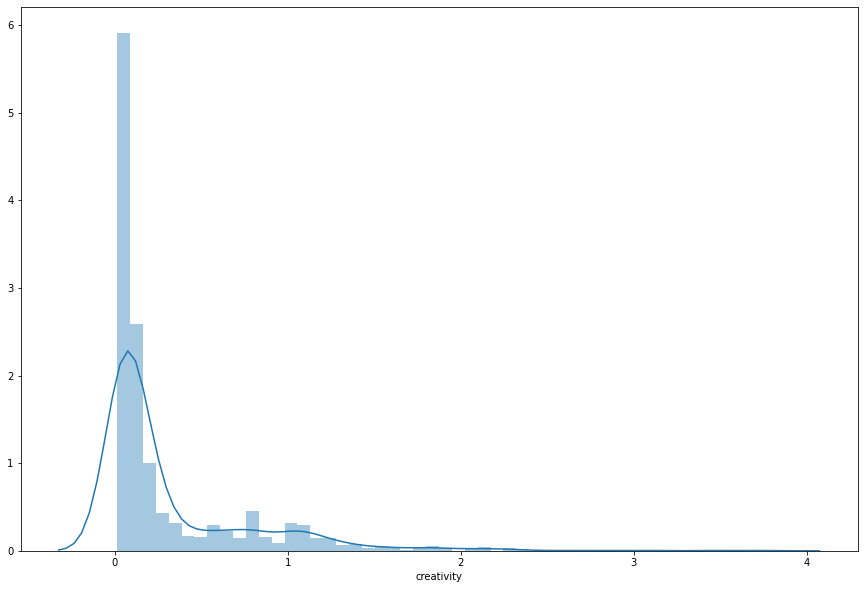

In [302]:
sns.distplot(cluster_games_df.creativity)

In [303]:
def summarize_player(*names):
    names = [n.lower() for n in names]
    series = cluster_games_df[cluster_games_df.self_name.str.lower().isin(names)].creativity
    print(series.describe())
    return sns.distplot(series)

def summarize_player_contains(name):
    all_names = set(creative_games_df[creative_games_df['self_name'].str.lower().str.contains(name.lower())].self_name)
    print("Names to use: {}".format(sorted(all_names)))
    return summarize_player(*all_names)

Names to use: ['<Mkers>MaxPax', '<QTcIub>MaxPax', 'MaxPax']
count    21.000000
mean      0.775154
std       0.726184
min       0.050637
25%       0.113840
50%       0.660265
75%       1.214162
max       2.267225
Name: creativity, dtype: float64


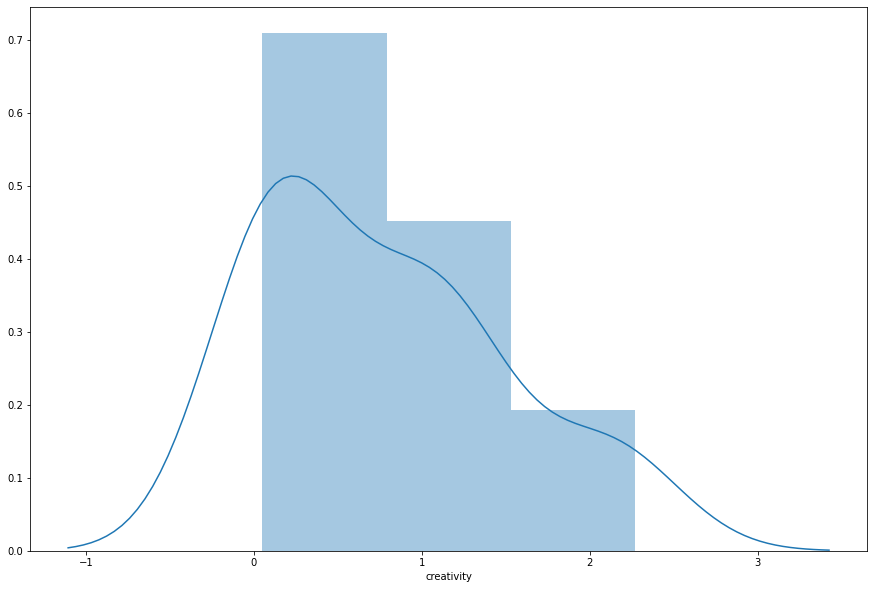

In [307]:
summarize_player_contains("maxpax")

Names to use: ['Dear']
count    59.000000
mean      0.218652
std       0.370227
min       0.015455
25%       0.033466
50%       0.085240
75%       0.177253
max       1.782490
Name: creativity, dtype: float64


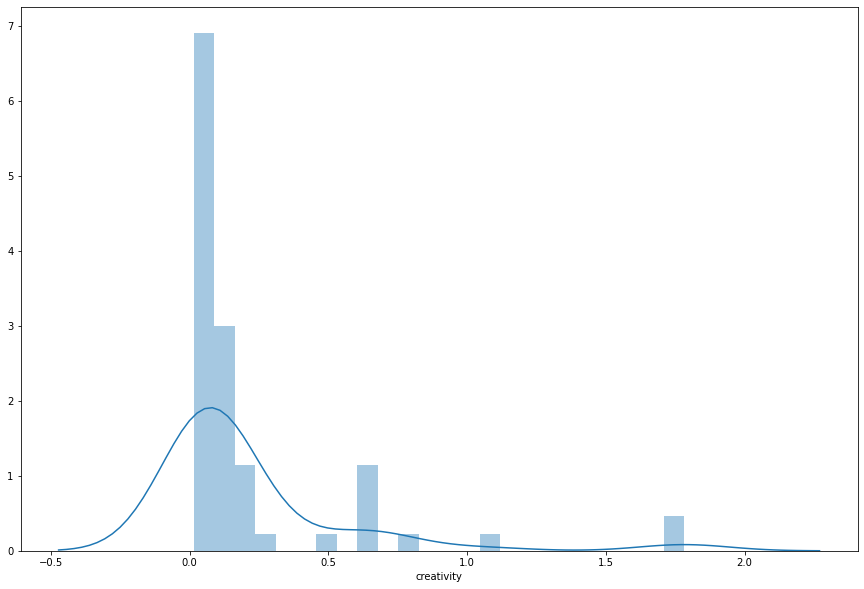

In [309]:
summarize_player_contains("dear")

Names to use: ['<QLASH>RotterdaM']
count    5.000000
mean     0.791178
std      0.869799
min      0.143395
25%      0.324916
50%      0.570178
75%      0.607478
max      2.309924
Name: creativity, dtype: float64


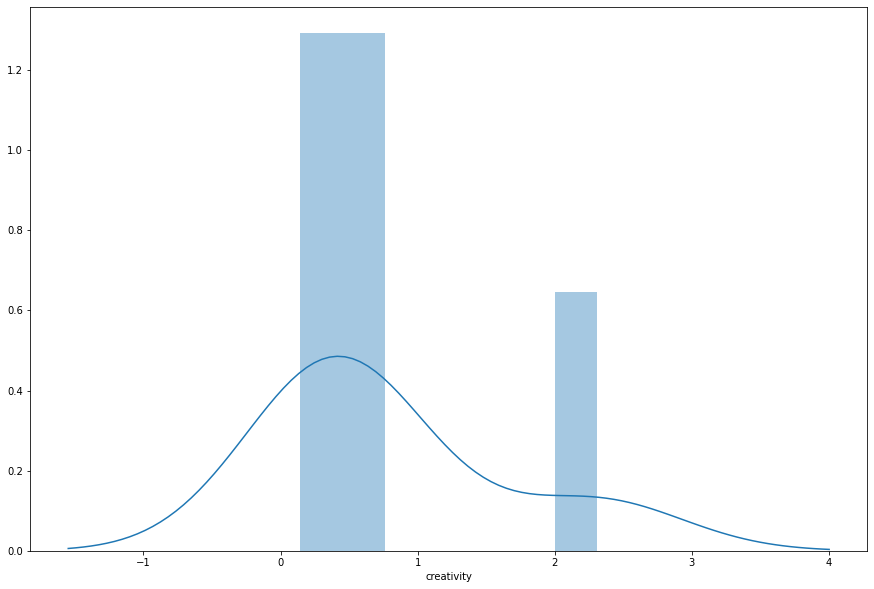

In [310]:
summarize_player_contains("rotterdam")

Names to use: ['<RYE>Zest', 'Zest']
count    106.000000
mean       0.347396
std        0.463644
min        0.015378
25%        0.053840
50%        0.126592
75%        0.616244
max        2.860462
Name: creativity, dtype: float64


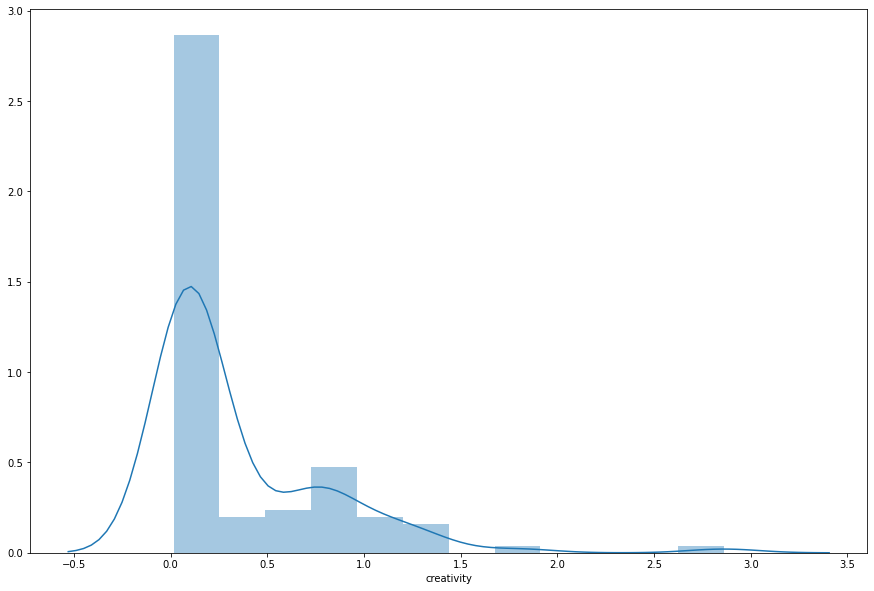

In [311]:
summarize_player_contains("zest")

Names to use: ['<cScNA>SKillous', '<сSсǃ>SKillous', 'SKillous']
count    51.000000
mean      0.440246
std       0.694935
min       0.023023
25%       0.057859
50%       0.187822
75%       0.571065
max       3.734894
Name: creativity, dtype: float64


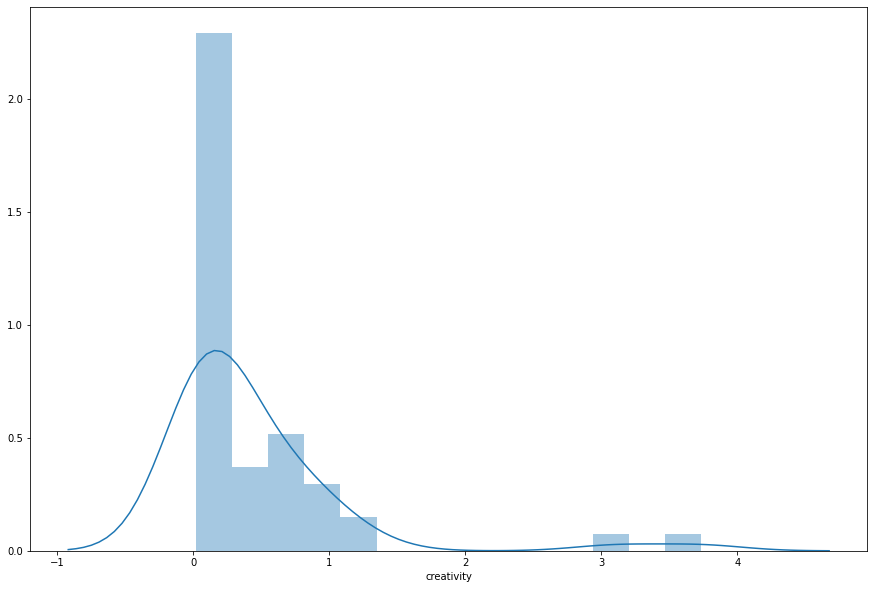

In [312]:
summarize_player_contains("skillous")